In [1]:
import sys
sys.path.append('..')

import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gaussian, threshold_otsu
from skimage.transform import resize
from skimage import io
import pickle
from skimage.measure import regionprops

import matplotlib.pyplot as plt
import torch
import time
from sklearn.decomposition import PCA
import pandas as pd
import torchvision

from PIL import Image 

import scanpy
import anndata as ad

import networkx as nx

In [3]:
sourceDir='/data/xinyi/c2p/data/chromark'
segDir=os.path.join(sourceDir,'nuclear_masks')
imgDir=os.path.join(sourceDir,'raw_data')
conditions=['controls','headneck','meningioma', 'glioma']

outSize=128
savename='pathCentered_'+str(outSize)

nmco_all_val={}
for condition_i in conditions:
#         print(condition_i)
    segDir_i=os.path.join(segDir,condition_i)
    imgDir_i=os.path.join(imgDir,condition_i)
    for stain in os.listdir(segDir_i):
#             print(stain)
        segDir_i_stain=os.path.join(segDir_i,stain)
        imgDir_i_stain=os.path.join(imgDir_i,stain)

        segPID2name={}
        for pID_dir in os.listdir(segDir_i_stain):
            pID=pID_dir.split('_')
            segPID2name[pID[0]]=pID_dir
        imgPID2name={}
        for pID_dir in os.listdir(imgDir_i_stain):
            pID=pID_dir.split('_')
            imgPID2name[pID[0]]=pID_dir
        for pID in segPID2name.keys():
            if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                continue
            if pID not in imgPID2name:
#                     print('img not found '+pID)
                continue
            imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
            segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])

            with open(os.path.join(imgDir_i_stain_p,'nmco_allfeatures_protein'), 'rb') as output:
                nmco_p=pickle.load(output) #excluding label column

            stain_list=stain.split('_')
            for sother in range(1,len(stain_list)):

                if stain_list[sother] not in nmco_all_val.keys():
                    nmco_all_val[stain_list[sother]]=nmco_p[stain_list[sother]]
                else:
                    nmco_all_val[stain_list[sother]]=np.concatenate((nmco_all_val[stain_list[sother]],nmco_p[stain_list[sother]]),axis=0)


In [7]:
for p in nmco_all_val.keys():
    print(p)
    nmco_all_finite=np.copy(nmco_all_val[p])
    nmco_all_finite[np.logical_not(np.isfinite(nmco_all_val[p]))]=0
    nmco_all_finite=nmco_all_finite[:,np.sum(np.isfinite(nmco_all_val[p]),axis=0)>0]

    print(nmco_all_finite.shape)
    with open(os.path.join(sourceDir,'nmco_allfeatures_names_'+p), 'rb') as output:
        nmco_names=pickle.load(output)
    nmco_names_finite=nmco_names[np.sum(np.isfinite(nmco_all_val[p]),axis=0)>0]

    with open(os.path.join(sourceDir,'nmco_allfeatures_names_finite_'+p), 'wb') as output:
        pickle.dump(nmco_names_finite,output,pickle.HIGHEST_PROTOCOL)
    
    df = pd.DataFrame(nmco_all_finite,columns=nmco_names_finite)
    corr = df.corr()
    # keep only upper triangle elements (excluding diagonal elements)
    mask_keep = np.triu(np.ones(corr.shape), k=1).astype('bool').reshape(corr.size)
    # melt (unpivot) the dataframe and apply mask
    sr = corr.stack(dropna=False)[mask_keep]
    # filter and get names
    edges = sr[sr > 0.8].reset_index().values[:, :2]
    g = nx.from_edgelist(edges)
    ls_cc = []
    ls_cc_order=[]
    for cc in nx.connected_components(g):
        ls_cc.append(list(cc))
        ls_cc_order.extend(list(cc))
    for n in nmco_names_finite:
        if n not in ls_cc_order:
            ls_cc.append([n])    
    
    print(len(ls_cc))
    print(ls_cc)
    
    with open(os.path.join(sourceDir,'ls_cc_'+p), 'wb') as output:
        pickle.dump(ls_cc,output,pickle.HIGHEST_PROTOCOL)
    
    
    ls_cc_mostConnected=[]
    for ccidx in range(len(ls_cc)):
        if len(ls_cc[ccidx])==1:
            maxDegree=0
            maxEle=ls_cc[ccidx][0]
        else:
            maxDegree=0
            maxEle=None
            for ccEle in ls_cc[ccidx]:
                if g.degree()[ccEle]>maxDegree:
                    maxDegree=g.degree()[ccEle]
                    maxEle=ccEle
        print('cc: '+str(ccidx))
        print(len(ls_cc[ccidx]))
        print(maxDegree)
        ls_cc_mostConnected.append(maxEle)
    
    print(ls_cc_mostConnected)
    with open(os.path.join(sourceDir,'ls_cc_mostConnected_'+p), 'wb') as output:
        pickle.dump(ls_cc_mostConnected,output,pickle.HIGHEST_PROTOCOL)

gh2ax
(15139, 21)
5
[['median_gh2ax_3d_int', 'min_gh2ax_2d_int', 'q75_gh2ax_2d_int', 'std_gh2ax_3d_int', 'q25_gh2ax_3d_int', 'max_gh2ax_2d_int', 'max_gh2ax_3d_int', 'min_gh2ax_3d_int', 'rel_gh2ax_2d_int', 'q75_gh2ax_3d_int', 'q25_gh2ax_2d_int', 'mean_gh2ax_2d_int', 'median_gh2ax_2d_int', 'mean_gh2ax_3d_int', 'std_gh2ax_2d_int', 'rel_gh2ax_3d_int'], ['skewness_gh2ax_3d_int', 'kurtosis_gh2ax_3d_int'], ['kurtosis_gh2ax_2d_int'], ['skewness_gh2ax_2d_int'], ['gh2ax_foci_count']]
cc: 0
16
12
cc: 1
2
1
cc: 2
1
0
cc: 3
1
0
cc: 4
1
0
['median_gh2ax_3d_int', 'skewness_gh2ax_3d_int', 'kurtosis_gh2ax_2d_int', 'skewness_gh2ax_2d_int', 'gh2ax_foci_count']
lamin
(15139, 20)
5
[['std_lamin_2d_int', 'q25_lamin_2d_int', 'rel_lamin_3d_int', 'max_lamin_2d_int', 'mean_lamin_2d_int', 'min_lamin_2d_int', 'median_lamin_2d_int', 'rel_lamin_2d_int', 'max_lamin_3d_int', 'q25_lamin_3d_int', 'std_lamin_3d_int', 'q75_lamin_2d_int', 'mean_lamin_3d_int', 'median_lamin_3d_int', 'q75_lamin_3d_int'], ['kurtosis_lamin_3d

gh2ax
(15139, 21)
5
[['median_gh2ax_3d_int', 'min_gh2ax_2d_int', 'q75_gh2ax_2d_int', 'std_gh2ax_3d_int', 'q25_gh2ax_3d_int', 'max_gh2ax_2d_int', 'max_gh2ax_3d_int', 'min_gh2ax_3d_int', 'rel_gh2ax_2d_int', 'q75_gh2ax_3d_int', 'q25_gh2ax_2d_int', 'mean_gh2ax_2d_int', 'median_gh2ax_2d_int', 'mean_gh2ax_3d_int', 'std_gh2ax_2d_int', 'rel_gh2ax_3d_int'], ['skewness_gh2ax_3d_int', 'kurtosis_gh2ax_3d_int'], ['kurtosis_gh2ax_2d_int'], ['skewness_gh2ax_2d_int'], ['gh2ax_foci_count']]
cc: 0
16
12
cc: 1
2
1
cc: 2
1
0
cc: 3
1
0
cc: 4
1
0
['median_gh2ax_3d_int', 'skewness_gh2ax_3d_int', 'kurtosis_gh2ax_2d_int', 'skewness_gh2ax_2d_int', 'gh2ax_foci_count']


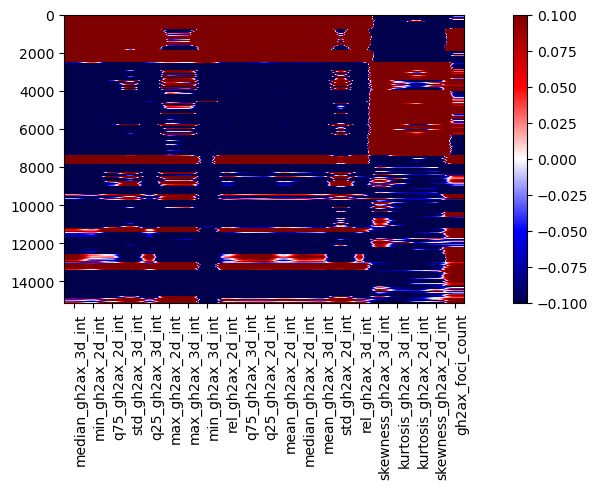

lamin
(15139, 20)
5
[['std_lamin_2d_int', 'q25_lamin_2d_int', 'rel_lamin_3d_int', 'max_lamin_2d_int', 'mean_lamin_2d_int', 'min_lamin_2d_int', 'median_lamin_2d_int', 'rel_lamin_2d_int', 'max_lamin_3d_int', 'q25_lamin_3d_int', 'std_lamin_3d_int', 'q75_lamin_2d_int', 'mean_lamin_3d_int', 'median_lamin_3d_int', 'q75_lamin_3d_int'], ['kurtosis_lamin_3d_int', 'skewness_lamin_3d_int'], ['kurtosis_lamin_2d_int'], ['skewness_lamin_2d_int'], ['min_lamin_3d_int']]
cc: 0
15
14
cc: 1
2
1
cc: 2
1
0
cc: 3
1
0
cc: 4
1
0
['q25_lamin_2d_int', 'kurtosis_lamin_3d_int', 'kurtosis_lamin_2d_int', 'skewness_lamin_2d_int', 'min_lamin_3d_int']


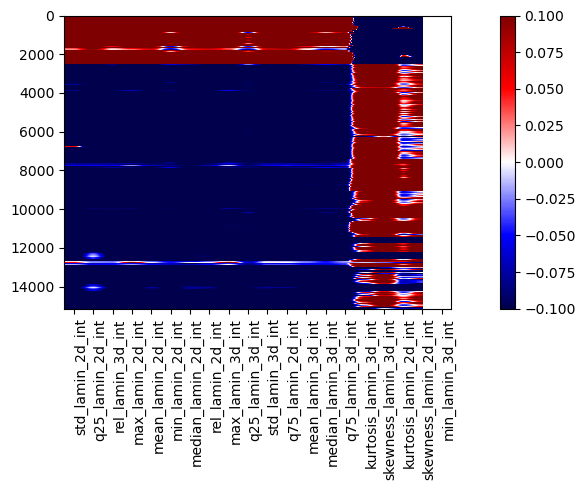

cd8
(17609, 20)
6
[['std_cd8_2d_int', 'rel_cd8_3d_int', 'mean_cd8_3d_int', 'mean_cd8_2d_int', 'max_cd8_3d_int', 'q75_cd8_2d_int', 'std_cd8_3d_int', 'median_cd8_2d_int', 'median_cd8_3d_int', 'rel_cd8_2d_int', 'max_cd8_2d_int'], ['q25_cd8_2d_int', 'q25_cd8_3d_int', 'q75_cd8_3d_int'], ['kurtosis_cd8_2d_int', 'skewness_cd8_2d_int'], ['skewness_cd8_3d_int', 'kurtosis_cd8_3d_int'], ['min_cd8_2d_int'], ['min_cd8_3d_int']]
cc: 0
11
10
cc: 1
3
2
cc: 2
2
1
cc: 3
2
1
cc: 4
1
0
cc: 5
1
0
['std_cd8_2d_int', 'q25_cd8_2d_int', 'kurtosis_cd8_2d_int', 'skewness_cd8_3d_int', 'min_cd8_2d_int', 'min_cd8_3d_int']


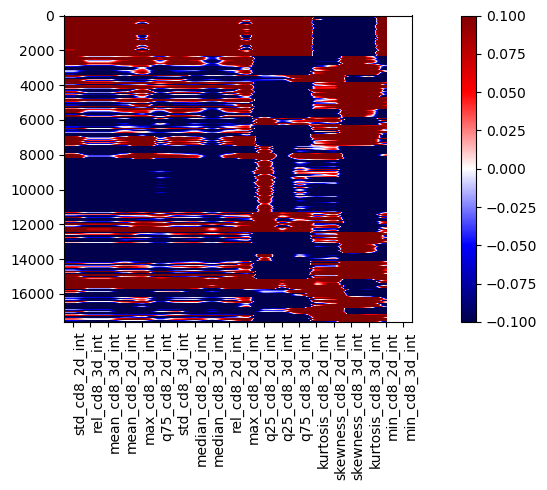

cd4
(17609, 20)
4
[['rel_cd4_2d_int', 'mean_cd4_3d_int', 'min_cd4_2d_int', 'std_cd4_3d_int', 'max_cd4_2d_int', 'median_cd4_2d_int', 'q25_cd4_3d_int', 'q75_cd4_2d_int', 'max_cd4_3d_int', 'mean_cd4_2d_int', 'q75_cd4_3d_int', 'std_cd4_2d_int', 'median_cd4_3d_int', 'q25_cd4_2d_int', 'rel_cd4_3d_int'], ['skewness_cd4_2d_int', 'kurtosis_cd4_2d_int'], ['skewness_cd4_3d_int', 'kurtosis_cd4_3d_int'], ['min_cd4_3d_int']]
cc: 0
15
14
cc: 1
2
1
cc: 2
2
1
cc: 3
1
0
['std_cd4_2d_int', 'skewness_cd4_2d_int', 'skewness_cd4_3d_int', 'min_cd4_3d_int']


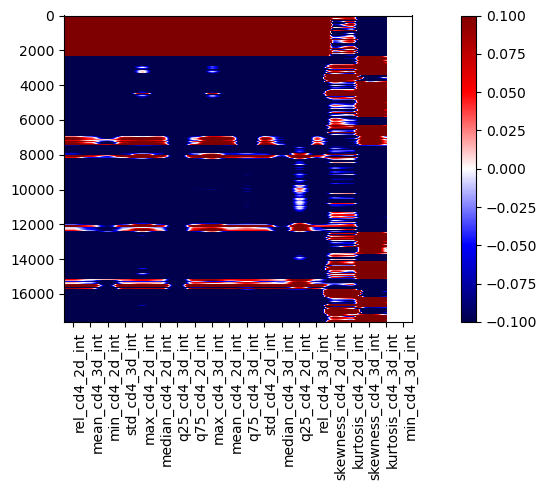

cd3
(12614, 20)
5
[['median_cd3_2d_int', 'max_cd3_2d_int', 'q25_cd3_2d_int', 'rel_cd3_3d_int', 'q25_cd3_3d_int', 'max_cd3_3d_int', 'mean_cd3_2d_int', 'rel_cd3_2d_int', 'std_cd3_2d_int', 'median_cd3_3d_int', 'q75_cd3_3d_int', 'mean_cd3_3d_int', 'std_cd3_3d_int', 'q75_cd3_2d_int'], ['kurtosis_cd3_2d_int', 'skewness_cd3_2d_int'], ['kurtosis_cd3_3d_int', 'skewness_cd3_3d_int'], ['min_cd3_2d_int'], ['min_cd3_3d_int']]
cc: 0
14
13
cc: 1
2
1
cc: 2
2
1
cc: 3
1
0
cc: 4
1
0
['q25_cd3_2d_int', 'kurtosis_cd3_2d_int', 'kurtosis_cd3_3d_int', 'min_cd3_2d_int', 'min_cd3_3d_int']


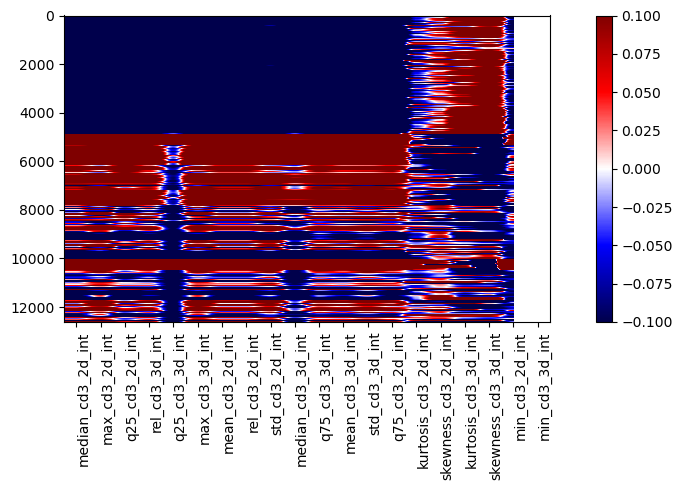

cd16
(15255, 20)
4
[['rel_cd16_3d_int', 'q75_cd16_2d_int', 'max_cd16_3d_int', 'median_cd16_3d_int', 'mean_cd16_3d_int', 'min_cd16_3d_int', 'median_cd16_2d_int', 'std_cd16_2d_int', 'min_cd16_2d_int', 'mean_cd16_2d_int', 'std_cd16_3d_int', 'rel_cd16_2d_int', 'max_cd16_2d_int'], ['q75_cd16_3d_int', 'q25_cd16_2d_int', 'q25_cd16_3d_int'], ['skewness_cd16_2d_int', 'kurtosis_cd16_2d_int'], ['skewness_cd16_3d_int', 'kurtosis_cd16_3d_int']]
cc: 0
13
10
cc: 1
3
2
cc: 2
2
1
cc: 3
2
1
['std_cd16_2d_int', 'q75_cd16_3d_int', 'skewness_cd16_2d_int', 'skewness_cd16_3d_int']


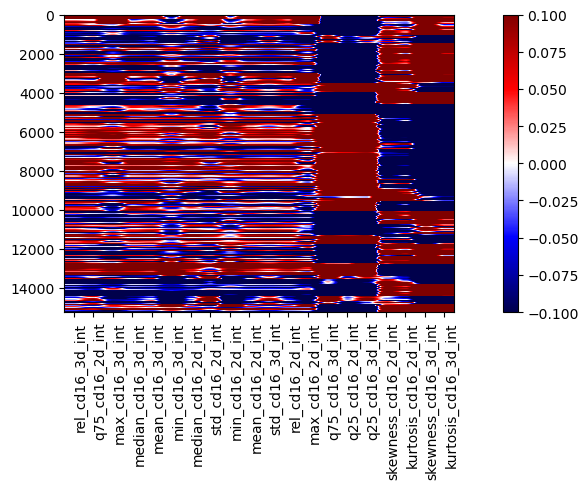

In [24]:
import scipy.stats
for p in nmco_all_val.keys():
    print(p)
    nmco_all_finite=np.copy(nmco_all_val[p])
    nmco_all_finite[np.logical_not(np.isfinite(nmco_all_val[p]))]=0
    nmco_all_finite=nmco_all_finite[:,np.sum(np.isfinite(nmco_all_val[p]),axis=0)>0]

    nmco_all_finite=scipy.stats.zscore(nmco_all_finite,axis=0,nan_policy='omit')
    
    print(nmco_all_finite.shape)
    with open(os.path.join(sourceDir,'nmco_allfeatures_names_'+p), 'rb') as output:
        nmco_names=pickle.load(output)
    nmco_names_finite=nmco_names[np.sum(np.isfinite(nmco_all_val[p]),axis=0)>0]

#     with open(os.path.join(sourceDir,'nmco_allfeatures_names_finite_'+p), 'wb') as output:
#         pickle.dump(nmco_names_finite,output,pickle.HIGHEST_PROTOCOL)
    
    df = pd.DataFrame(nmco_all_finite,columns=nmco_names_finite)
    corr = df.corr()
    mask_keep = np.triu(np.ones(corr.shape), k=1).astype('bool').reshape(corr.size)
    sr = corr.stack(dropna=False)[mask_keep]
    # filter and get names
    edges = sr[sr > 0.8].reset_index().values[:, :2]
    g = nx.from_edgelist(edges)
    ls_cc = []
    ls_cc_order=[]
    for cc in nx.connected_components(g):
        ls_cc.append(list(cc))
        ls_cc_order.extend(list(cc))
    for n in nmco_names_finite:
        if n not in ls_cc_order:
            ls_cc.append([n])
            ls_cc_order.append(n)
    
    print(len(ls_cc))
    print(ls_cc)
    
    with open(os.path.join(sourceDir,'ls_cc_'+p), 'wb') as output:
        pickle.dump(ls_cc,output,pickle.HIGHEST_PROTOCOL)
    
    
    ls_cc_mostConnected=[]
    for ccidx in range(len(ls_cc)):
        if len(ls_cc[ccidx])==1:
            maxDegree=0
            maxEle=ls_cc[ccidx][0]
        else:
            maxDegree=0
            maxEle=None
            for ccEle in ls_cc[ccidx]:
                if g.degree()[ccEle]>maxDegree:
                    maxDegree=g.degree()[ccEle]
                    maxEle=ccEle
        print('cc: '+str(ccidx))
        print(len(ls_cc[ccidx]))
        print(maxDegree)
        ls_cc_mostConnected.append(maxEle)
    
    print(ls_cc_mostConnected)
#     with open(os.path.join(sourceDir,'ls_cc_mostConnected_'+p), 'wb') as output:
#         pickle.dump(ls_cc_mostConnected,output,pickle.HIGHEST_PROTOCOL)

    df_plot=df.copy()[ls_cc_order]

    fig, ax = plt.subplots(figsize=(10, 5))
#     im = ax.imshow(df_plot.to_numpy(),cmap='seismic',vmin=-np.max(np.abs(df_plot.to_numpy())),vmax=np.max(np.abs(df_plot.to_numpy())),aspect=0.001)
    im = ax.imshow(df_plot.to_numpy(),cmap='seismic',vmin=-0.1,vmax=0.1,aspect=0.001)
    ax.set_xticks(np.arange(nmco_names_finite.size))
    ax.set_xticklabels(ls_cc_order)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")
    fig.colorbar(im)
    fig.tight_layout()
    # plt.savefig(os.path.join(nmcodesavepath,'nmco_groups.jpg'))
    plt.show()

In [12]:
ls_cc_order

['median_gh2ax_3d_int',
 'min_gh2ax_2d_int',
 'q75_gh2ax_2d_int',
 'std_gh2ax_3d_int',
 'q25_gh2ax_3d_int',
 'max_gh2ax_2d_int',
 'max_gh2ax_3d_int',
 'min_gh2ax_3d_int',
 'rel_gh2ax_2d_int',
 'q75_gh2ax_3d_int',
 'q25_gh2ax_2d_int',
 'mean_gh2ax_2d_int',
 'median_gh2ax_2d_int',
 'mean_gh2ax_3d_int',
 'std_gh2ax_2d_int',
 'rel_gh2ax_3d_int',
 'skewness_gh2ax_3d_int',
 'kurtosis_gh2ax_3d_int',
 ['kurtosis_gh2ax_2d_int'],
 ['skewness_gh2ax_2d_int'],
 ['gh2ax_foci_count']]